In [94]:
import pandas as pd
import numpy as np
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split

import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


## Load datasets
Read the CSV files and display their shapes and a quick preview.


In [95]:
# Load all CSVs
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
users = pd.read_csv('users.csv')
ratings_movies = pd.read_csv('ratings_movies.csv')

# Show dataset shapes
print("Dataset shapes:")
print(f"Ratings: {ratings.shape}")
print(f"Movies: {movies.shape}")
print(f"Users: {users.shape}")
print(f"Ratings_Movies: {ratings_movies.shape}")

# Display previews
import IPython.display as disp
disp.display(ratings.head())
disp.display(movies.head())

Dataset shapes:
Ratings: (100000, 4)
Movies: (1682, 24)
Users: (943, 5)
Ratings_Movies: (100000, 6)


,user_id,movie_id,rating,datetime
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Train/Test split
Split the ratings by user IDs into training (80%) and testing (20%) sets.


In [96]:
from sklearn.model_selection import train_test_split

# Get unique users
unique_users = ratings['user_id'].unique()

# Split users into train/test
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

# Create train and test ratings
train_ratings = ratings[ratings['user_id'].isin(train_users)]
test_ratings  = ratings[ratings['user_id'].isin(test_users)]

# Summary
print(f"Train ratings: {len(train_ratings)}")
print(f"Test ratings: {len(test_ratings)}")
print(f"Train users: {len(train_users)}, Test users: {len(test_users)}")

Train ratings: 79734
Test ratings: 20266
Train users: 754, Test users: 189


## Build sparse user–item matrix
Convert the ratings DataFrame into a sparse user–item matrix and create ID mappers.


In [97]:
def build_sparse_matrix(df, user_col='user_id', item_col='movie_id', rating_col='rating'):
    # Extract unique IDs
    user_ids = df[user_col].unique()
    movie_ids = df[item_col].unique()

    # Create mapping dictionaries
    user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
    movie_id_map = {mid: idx for idx, mid in enumerate(movie_ids)}

    # Map rows and columns
    rows = df[user_col].map(user_id_map)
    cols = df[item_col].map(movie_id_map)
    values = df[rating_col].values

    # Build sparse matrix
    sparse_matrix = sparse.csr_matrix((values, (rows, cols)),
                                      shape=(len(user_ids), len(movie_ids)))
    return sparse_matrix, user_id_map, movie_id_map


# Build train and test matrices
train_matrix, user_id_map, movie_id_map = build_sparse_matrix(train_ratings)
test_matrix, _, _ = build_sparse_matrix(test_ratings)

# Shapes summary
print(f"Train matrix shape: {train_matrix.shape}")
print(f"Test matrix shape: {test_matrix.shape}")

Train matrix shape: (754, 1661)
Test matrix shape: (189, 1404)


## Helper functions
Utility functions to filter movies already seen by a user and to compute a popularity-based baseline.


In [98]:
def filter_seen_movies(user_id, user_id_map, movie_id_map, ratings_df):
    """Return the set of movies already rated by a specific user."""
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    return set(user_ratings['movie_id'])


def popularity_baseline(ratings_df, n=10):
    """Return the top-n most popular movies ranked by number of ratings."""
    movie_popularity = ratings_df['movie_id'].value_counts()
    return movie_popularity.head(n).index.tolist()


# Quick test
sample_user = train_users[0]
seen_movies = filter_seen_movies(sample_user, user_id_map, movie_id_map, train_ratings)
top_popular = popularity_baseline(train_ratings, 10)

print(f"Sample user {sample_user} has seen {len(seen_movies)} movies.")
print(f"Top 10 popular movies (IDs): {top_popular[:5]}...")

Sample user 140 has seen 21 movies.
Top 10 popular movies (IDs): [50, 100, 181, 258, 294]...


## Baseline models
Implement simple baseline approaches:
- Global mean: predict the same mean rating for all.
- Movie bias: predict using the mean rating per movie.
- User + Movie bias: fallback to user mean if movie mean is missing.


In [99]:
def evaluate_predictions(y_true, y_pred, model_name):
    """Compute RMSE and MAE for a given model."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae}


# Global mean baseline
global_mean = train_ratings['rating'].mean()
global_preds = [global_mean] * len(test_ratings)
global_results = evaluate_predictions(test_ratings['rating'], global_preds, 'Global Mean')

# Movie bias baseline
movie_means = train_ratings.groupby('movie_id')['rating'].mean()
movie_preds = test_ratings['movie_id'].map(movie_means).fillna(global_mean)
movie_results = evaluate_predictions(test_ratings['rating'], movie_preds, 'Movie Bias')

# User + Movie bias baseline
user_means = train_ratings.groupby('user_id')['rating'].mean()
user_movie_preds = test_ratings.apply(
    lambda x: movie_means.get(x['movie_id'], user_means.get(x['user_id'], global_mean)), axis=1
)
user_movie_results = evaluate_predictions(test_ratings['rating'], user_movie_preds, 'User+Movie Bias')

# Collect results
baseline_results = pd.DataFrame([global_results, movie_results, user_movie_results])

print("Baseline Models Performance:")
display(baseline_results)

Baseline Models Performance:


,Model,RMSE,MAE
0,Global Mean,1.094195,0.921892
1,Movie Bias,0.998183,0.796315
2,User+Movie Bias,0.998183,0.796315


## Collaborative Filtering (sklearn)
Implement User–User and Item–Item collaborative filtering using k-Nearest Neighbors.


In [100]:
def collaborative_filtering(train_matrix, test_matrix, mode='user', k=50, metric='cosine'):
    """Perform User–User or Item–Item collaborative filtering."""

    if mode == 'user':
        # Align matrices on common items
        common_items = min(train_matrix.shape[1], test_matrix.shape[1])
        train_matrix_common = train_matrix[:, :common_items]
        test_matrix_common = test_matrix[:, :common_items]

        model = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute')
        model.fit(train_matrix_common)
        distances, indices = model.kneighbors(test_matrix_common)

    else:  # item–item
        # Align matrices on common users
        common_users = min(train_matrix.shape[0], test_matrix.shape[0])
        train_matrix_common = train_matrix[:common_users, :]
        test_matrix_common = test_matrix[:common_users, :]

        model = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute')
        model.fit(train_matrix_common.T)
        distances, indices = model.kneighbors(test_matrix_common.T)

    return distances, indices


# Run User–User CF
user_distances, user_indices = collaborative_filtering(train_matrix, test_matrix, mode='user', k=50)

# Run Item–Item CF
item_distances, item_indices = collaborative_filtering(train_matrix, test_matrix, mode='item', k=50)

print("Collaborative Filtering models trained successfully!")
print(f"User–User CF: {user_indices.shape} neighbors found")
print(f"Item–Item CF: {item_indices.shape} neighbors found")

Collaborative Filtering models trained successfully!
User–User CF: (189, 51) neighbors found
Item–Item CF: (1404, 51) neighbors found


## Collaborative Filtering (Surprise)
Use the Surprise library to implement User–User and Item–Item collaborative filtering with cosine similarity.


In [101]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy

# Convert ratings DataFrame into a Surprise Dataset
reader = Reader(rating_scale=(ratings['rating'].min(), ratings['rating'].max()))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Split into train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# --- User-based CF ---
user_cf = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': True})
user_cf.fit(trainset)
user_cf_predictions = user_cf.test(testset)
user_cf_rmse = accuracy.rmse(user_cf_predictions, verbose=False)
user_cf_mae = accuracy.mae(user_cf_predictions, verbose=False)

# --- Item-based CF ---
item_cf = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
item_cf.fit(trainset)
item_cf_predictions = item_cf.test(testset)
item_cf_rmse = accuracy.rmse(item_cf_predictions, verbose=False)
item_cf_mae = accuracy.mae(item_cf_predictions, verbose=False)

print("Collaborative Filtering with Surprise:")
print(f"User-Based CF - RMSE: {user_cf_rmse:.4f}, MAE: {user_cf_mae:.4f}")
print(f"Item-Based CF - RMSE: {item_cf_rmse:.4f}, MAE: {item_cf_mae:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Collaborative Filtering with Surprise:
User-Based CF - RMSE: 1.0187, MAE: 0.8037
Item-Based CF - RMSE: 1.0249, MAE: 0.8091


## Matrix Factorization (SVD)
Train an SVD model using Surprise and evaluate its performance.


In [102]:
from surprise import SVD
from surprise import accuracy

# Train SVD model
svd = SVD()
svd.fit(trainset)

# Predict on the test set
svd_predictions = svd.test(testset)

# Evaluate
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
svd_mae = accuracy.mae(svd_predictions, verbose=False)

print(f"SVD - RMSE: {svd_rmse:.4f}, MAE: {svd_mae:.4f}")

SVD - RMSE: 0.9345, MAE: 0.7367


## Model comparison
Combine baseline models, collaborative filtering, and SVD into one summary table.


In [103]:
# CF results
cf_results = [
    {'Model': 'User-Based CF', 'RMSE': user_cf_rmse, 'MAE': user_cf_mae},
    {'Model': 'Item-Based CF', 'RMSE': item_cf_rmse, 'MAE': item_cf_mae}
]

# Append all models into a single DataFrame
model_comparison = baseline_results.copy()
model_comparison = model_comparison._append(cf_results, ignore_index=True)
model_comparison = model_comparison._append({
    'Model': 'SVD',
    'RMSE': svd_rmse,
    'MAE': svd_mae
}, ignore_index=True)

print("UPDATED MODEL COMPARISON:")
print("=" * 40)
display(model_comparison)

UPDATED MODEL COMPARISON:


,Model,RMSE,MAE
0,Global Mean,1.094195,0.921892
1,Movie Bias,0.998183,0.796315
2,User+Movie Bias,0.998183,0.796315
3,User-Based CF,1.018721,0.803668
4,Item-Based CF,1.024947,0.809104
5,SVD,0.934534,0.736699


## Visualization
Compare all models by plotting RMSE and MAE side by side.


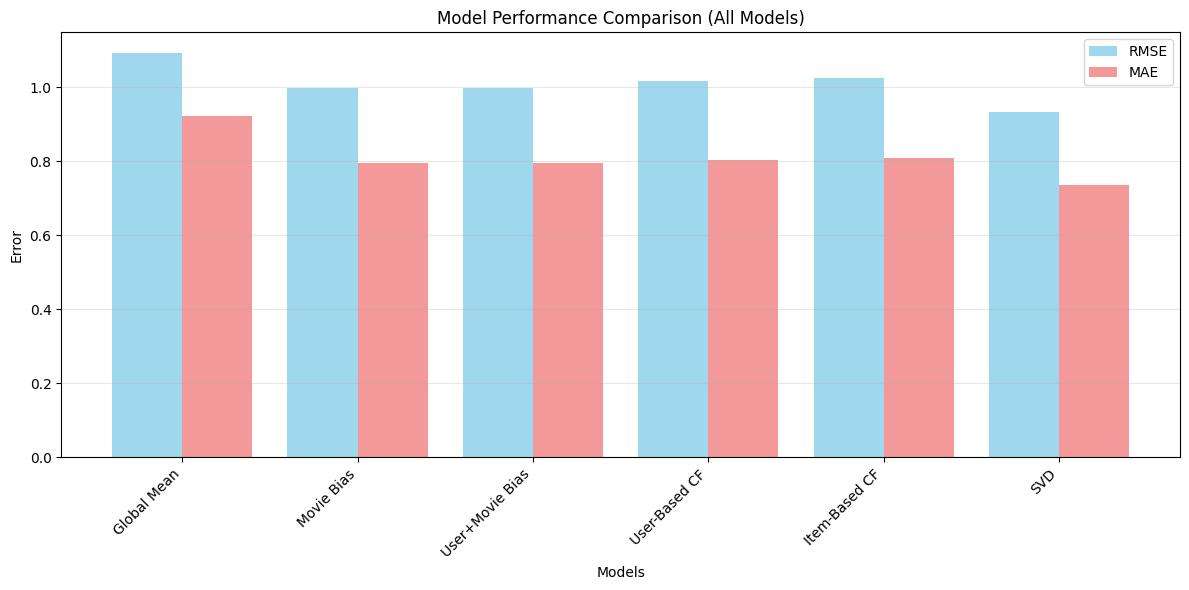

In [104]:
plt.figure(figsize=(12, 6))

x_pos = np.arange(len(model_comparison))

# Plot RMSE and MAE as grouped bars
plt.bar(x_pos - 0.2, model_comparison['RMSE'], width=0.4,
        label='RMSE', alpha=0.8, color='skyblue')
plt.bar(x_pos + 0.2, model_comparison['MAE'], width=0.4,
        label='MAE', alpha=0.8, color='lightcoral')

# Labels and formatting
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Performance Comparison (All Models)')
plt.xticks(x_pos, model_comparison['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

## Matrix Factorization with Surprise (SVD)
Train an SVD model for rating prediction and evaluate it using RMSE and MAE.


In [105]:
# Prepare Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Train/test split
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
svd = SVD(n_factors=50, random_state=42)
svd.fit(trainset)

# Predictions
svd_predictions = svd.test(testset)

# Evaluate
svd_rmse = np.sqrt(mean_squared_error([p.r_ui for p in svd_predictions],
                                      [p.est for p in svd_predictions]))
svd_mae = mean_absolute_error([p.r_ui for p in svd_predictions],
                              [p.est for p in svd_predictions])

print(f"SVD RMSE: {svd_rmse:.4f}")
print(f"SVD MAE: {svd_mae:.4f}")

SVD RMSE: 0.9348
SVD MAE: 0.7377


## Unified API
Define a `RecommendationSystem` class that provides consistent methods for:
- Predicting ratings with different models (global mean, bias models, SVD).
- Generating top-N movie recommendations for a given user.


In [106]:
class RecommendationSystem:
    def __init__(self, ratings_df, movies_df, user_id_map, movie_id_map, svd_model):
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.user_id_map = user_id_map
        self.movie_id_map = movie_id_map
        self.svd_model = svd_model

        # Precompute baselines
        self.global_mean = ratings_df['rating'].mean()
        self.movie_means = ratings_df.groupby('movie_id')['rating'].mean()
        self.user_means = ratings_df.groupby('user_id')['rating'].mean()

    def predict_rating(self, user_id, movie_id, model_name='svd'):
        """Predict a rating for a given user and movie using the chosen model."""
        if model_name == 'global_mean':
            return self.global_mean

        elif model_name == 'movie_bias':
            return self.movie_means.get(movie_id, self.global_mean)

        elif model_name == 'user_movie_bias':
            user_mean = self.user_means.get(user_id, self.global_mean)
            return self.movie_means.get(movie_id, user_mean)

        elif model_name == 'svd':
            try:
                return self.svd_model.predict(user_id, movie_id).est
            except:
                return self.movie_means.get(movie_id, self.global_mean)

        else:
            return self.global_mean

    def recommend_top_n(self, user_id, n=10, exclude_seen=True, model_name='svd'):
        """Recommend top-N movies for a given user using the specified model."""

        # Handle cold-start (new user)
        if user_id not in self.user_means.index:
            popular_movies = self.ratings_df['movie_id'].value_counts().head(n).index.tolist()
            return self.movies_df[self.movies_df['movie_id'].isin(popular_movies)]

        # Exclude movies already rated
        seen_movies = set()
        if exclude_seen:
            seen_movies = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['movie_id'])

        # Predict ratings for all unseen movies
        predictions = []
        for movie_id in self.movies_df['movie_id']:
            if movie_id not in seen_movies:
                pred = self.predict_rating(user_id, movie_id, model_name)
                predictions.append((movie_id, pred))

        # Sort by predicted rating and select top-N
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_movie_ids = [x[0] for x in predictions[:n]]

        return self.movies_df[self.movies_df['movie_id'].isin(top_movie_ids)]


# Initialize recommendation system
rec_system = RecommendationSystem(train_ratings, movies, user_id_map, movie_id_map, svd)


## Reporting
Summarize dataset statistics, compare model performance, and display sample recommendations.


In [107]:
# --- Dataset statistics ---
print("DATASET STATISTICS:")
print("=" * 20)
print(f"Total ratings: {len(ratings)}")
print(f"Total users: {ratings['user_id'].nunique()}")
print(f"Total movies: {ratings['movie_id'].nunique()}")
print(f"Average rating: {ratings['rating'].mean():.2f}")
print("\nRating distribution:")
display(ratings['rating'].value_counts().sort_index())

DATASET STATISTICS:
Total ratings: 100000
Total users: 943
Total movies: 1682
Average rating: 3.53

Rating distribution:


,count
rating,
1,6110
2,11370
3,27145
4,34174
5,21201


In [108]:
# --- Model comparison ---
model_comparison = baseline_results.copy()
model_comparison = model_comparison._append({
    'Model': 'SVD',
    'RMSE': svd_rmse,
    'MAE': svd_mae
}, ignore_index=True)

print("MODEL COMPARISON:")
print("=" * 20)
display(model_comparison)

MODEL COMPARISON:


,Model,RMSE,MAE
0,Global Mean,1.094195,0.921892
1,Movie Bias,0.998183,0.796315
2,User+Movie Bias,0.998183,0.796315
3,SVD,0.934761,0.737693


In [109]:
# --- Example recommendations ---
sample_user = test_users[0]
recommendations = rec_system.recommend_top_n(sample_user, n=5)

print(f"Top 5 recommendations for user {sample_user}:")
display(recommendations[['movie_id', 'title']])

Top 5 recommendations for user 262:


,movie_id,title
49,50,Star Wars (1977)
99,100,Fargo (1996)
180,181,Return of the Jedi (1983)
257,258,Contact (1997)
293,294,Liar Liar (1997)


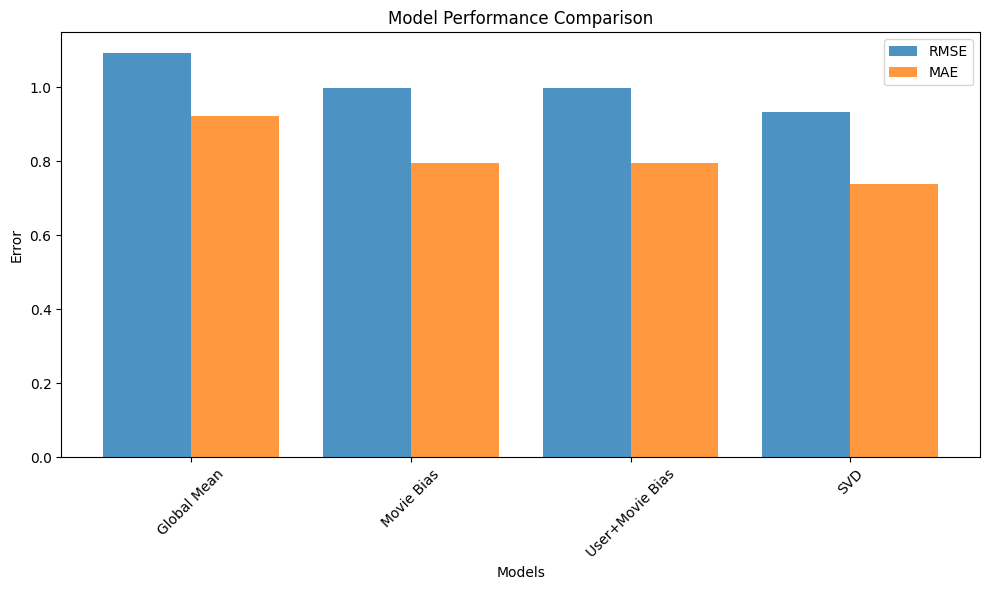

In [110]:
# --- Visualization: model performance comparison ---
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(model_comparison))

plt.bar(x_pos - 0.2, model_comparison['RMSE'], width=0.4, label='RMSE', alpha=0.8)
plt.bar(x_pos + 0.2, model_comparison['MAE'], width=0.4, label='MAE', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, model_comparison['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Ranking metrics functions
Define helper functions to compute Precision@K, Recall@K, and NDCG@K.


In [111]:
from collections import defaultdict
from math import log2

def get_top_n(predictions, n=10):
    """Return top-N predictions for each user from Surprise predictions."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]
    return top_n

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Compute precision@K and recall@K for all users."""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

def ndcg_at_k(predictions, k=10):
    """Compute NDCG@K for all users."""
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    ndcgs = {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        dcg, idcg = 0.0, 0.0
        for rank, (_, true_r) in enumerate(user_ratings[:k], start=1):
            rel = 1 if true_r >= 3.5 else 0
            dcg += rel / log2(rank + 1)
        ideal_ratings = sorted([1 if r >= 3.5 else 0 for (_, r) in user_ratings], reverse=True)
        for rank, rel in enumerate(ideal_ratings[:k], start=1):
            idcg += rel / log2(rank + 1)
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0
    return ndcgs

In [112]:
# Evaluate on SVD predictions
precisions, recalls = precision_recall_at_k(svd_predictions, k=10, threshold=3.5)
ndcgs = ndcg_at_k(svd_predictions, k=10)

print(f"Precision@10: {np.mean(list(precisions.values())):.4f}")
print(f"Recall@10:    {np.mean(list(recalls.values())):.4f}")
print(f"NDCG@10:      {np.mean(list(ndcgs.values())):.4f}")

Precision@10: 0.7135
Recall@10:    0.5454
NDCG@10:      0.8298


## Find similar movies by title or ID
Get top-N most similar movies to a given movie (using SVD latent factors).


In [118]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_movies(movie_input, svd_model, movies_df, trainset, top_n=5):

    # Handle input type (title → movie_id)
    if isinstance(movie_input, str):
        match = movies_df[movies_df['title'].str.contains(movie_input, case=False, na=False)]
        if match.empty:
            raise ValueError(f"No movie found with title containing '{movie_input}'")
        movie_id = match.iloc[0]['movie_id']
    else:
        movie_id = movie_input

    # Convert raw movie_id to Surprise inner id
    try:
        inner_id = trainset.to_inner_iid(movie_id)
    except ValueError:
        raise ValueError(f"Movie ID {movie_id} not found in training set")

    # Extract item factors from SVD
    item_factors = svd_model.qi

    # Compute cosine similarity with all items
    sims = cosine_similarity([item_factors[inner_id]], item_factors)[0]

    # Get top-N indices (exclude the movie itself)
    similar_indices = sims.argsort()[::-1][1:top_n+1]

    # Map back to raw IDs
    similar_movie_ids = [trainset.to_raw_iid(idx) for idx in similar_indices]

    return movies_df[movies_df['movie_id'].isin(similar_movie_ids)][['movie_id', 'title']]


In [ ]:
# By movie_id
display(get_similar_movies(50, svd, movies, trainset, top_n=5))

# By title (case-insensitive search)
display(get_similar_movies("Toy Story", svd, movies, trainset, top_n=5))

,movie_id,title
171,172,"Empire Strikes Back, The (1980)"
173,174,Raiders of the Lost Ark (1981)
180,181,Return of the Jedi (1983)
190,191,Amadeus (1984)
233,234,Jaws (1975)


,movie_id,title
16,17,From Dusk Till Dawn (1996)
17,18,"White Balloon, The (1995)"
419,420,Alice in Wonderland (1951)
1249,1250,Best of the Best 3: No Turning Back (1995)
1619,1620,"Sixth Man, The (1997)"
